<a href="https://colab.research.google.com/github/hillbig/medical-ai-course-materials/blob/master/notebooks/DNA_Sequence_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![colab-logo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/DNA_Sequence_Data_Analysis.ipynb)

# 実践編：ディープラーニングを使った配列解析

近年，次世代シーケンサ（NGS; Next Generation Sequencer）の発展により，遺伝子の塩基配列が高速，大量，安価に読み取られるようになってきました。

ここではディープラーニングを用いて，DNA配列からエピジェネティックな影響や転写制御を予測する問題に取り組みます．ディープラーニングは複雑なモデルを表現でき、遠距離の影響も考慮することができます．この予測モデルを使うことで，ある遺伝子変異が遺伝子発現にどのような影響を与えるのかを予測することができるようになります．









## 環境構築

ここで用いるライブラリは


*  Chainer
*  Cupy
*  matplotlib

です．Google Colab上では，以下のようにしてインストールすることができます．以下のセルを実行（Shit+Enter）してください．


In [0]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2
!pip install cupy-cuda92==6.0.0a1
!pip install chainer==6.0.0a1

インストールが完了したら，以下のセルを実行して，各ライブラリのバージョンを確認してください．



In [0]:
import chainer
import cupy
import matplotlib

chainer.print_runtime_info()
print('matplotlib:', matplotlib.__version__)

```
Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.0.0a1
NumPy: 1.14.6
CuPy:
  CuPy Version          : 6.0.0a1
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
('matplotlib:', '2.1.2')
```

## 配列解析について

次世代シーケンサの発展・普及とともに，大量の遺伝子配列が読み取られるようになりました．そうした中で，塩基配列で表現された遺伝子型と病気や形態などの表現型との関係を推定するようなGWAS（Genome Wide Association Study; ゲノムワイド関連解析）が行われてきましたが，遺伝子の変異だけでは全ての表現型の変化を説明できないことがわかってきました．特に，非翻訳領域が遺伝子発現に影響を与え，表現型の変化を生じさせていることが様々な実験結果からわかってきています．遺伝子発現時に周辺領域がどのように影響を与えているのかを調べるために様々な手法が提案されています．（以下図）

![代替テキスト](https://www.encodeproject.org/images/c45f4d8c-0340-4fcb-abe3-e4ff0bb919be/@@download/attachment/EncodeDatatypes2013-7.png)
[Encode Projectより引用]

例えば，ChIP-Seq（クロマチン免疫沈降）は，転写調節因子やそのほかのタンパク質が直接の相互作用を起こすDNAの特定部位を分離し，それらをシーケンシングして同定し，どの程度出現していたかを定量化します．これにより，タンパク質のDNA中の結合部位を正確かつ効率的に同定することができます．

このような技術で抽出された配列を学習データとして利用し，DNA配列のみからそこが結合部位かどうかだけでなく，どの程度，出現していたのかというカバレッジ値を推定します．例えば，修飾ヒストンのChiPの学習データを利用した場合はDNA配列を入力としてそのどこがヒストン修飾サイトであるかを推定できるようになります，様々な種類の実験データを学習データと用いることでDNA配列から，転写因子，クロマチンアクセシビリティ，ヒストン修飾を予測することができるようになり，様々な遺伝子変異に対する有益な洞察を与えてくれます．

一方で，DNA配列中のどの領域がそのような特徴を持つのかを調べるためには非常に遠距離のDNA配列も必要である場合が多く，これが機械学習による解析を困難としていました．今回紹介する手法はこのような遠距離の関係を捉えるため，10万超の長さのDNA配列を入力として受け取り，128 bpごとにその領域がどの程度各手法で発現していたのか，カバレッジ値を予測するタスクを考えます．

## データセット

ここでは，Basenji[1]で使われた実験データセットの一部を利用します.これらはCAGEなどの配列解析した結果に作られたデータ・セットです。

下のセルを実行してデータをダウンロードしてください．

この配列はそれぞれが長さ131072からなり，128塩基毎に対しそのカバレッジ値が記録されています。このカバレッジ値の配列の長さは131072/128=1024です．

この問題の目標は長さ131072の配列を入力として受け取った時に、この128塩基毎のカバレッジ値を推定することが目標です。

今回は10種類の異なる実験のカバレッジ値を同時に予測する問題を扱います。

In [0]:
!wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/seq.h5


In [6]:
!ls -lh

total 567M
-rw-r--r-- 1 root root 2.6K Dec  3 06:46 adc.json
drwxr-xr-x 2 root root 4.0K Nov 29 18:21 sample_data
-rw-r--r-- 1 root root 567M Dec  3 06:47 seq.h5


data.h5というファイルが正しくダウンロードされているかを確認してください．サイズは567MBです．

data.h5はHDF5形式でデータを格納したファイルです．HDF5ファイルは，ファイルシステムと同様に，階層的にデータを格納することができ，行列やテンソルデータをそれぞれの位置で名前付きで格納することができます．

HDF5形式のファイルを操作するためにh5pyというライブラリがあります．h5pyのFile()関数でファイルを開き，keys()関数でその中に含まれているキーを列挙します．また取得したキーを'[]'内で指定することでそのキーに紐付けられて格納されている各データを参照することができます．

テンソルデータはnumpyと同様にshapeという属性でそのサイズを取得することができます．

以下のセルを実行して格納されているデータを確認してください．

各データの名前にtrain（学習）、validate（検証）、test（テスト）の接頭辞がつけられ、inが入力の塩基配列、outが出力のカバレッジ値に対応します．

例えば，'train_in'は学習用の入力データであり(6240, 131072, 4)というサイズを持ちます．これは長さが130172からなる配列が6240個あり，それぞれA, T, C, Gの対応する次元の値が1, それ以外は0であるような配列です．

また,'train_out'は学習用の出力データであり,（'6240, 1024, 3')というサイズを持ちます.これは長さが1024からなる配列が6240個あり,それぞれが3種類の異なるChipSeqの結果のカバレッジ値が格納されています.

In [9]:
import h5py
import numpy as np

with h5py.File('seq.h5', 'r') as hf:
    for key in hf.keys():
        print(key, hf[key].shape, hf[key].dtype)

(u'target_labels', (10,), dtype('S29'))
(u'test_in', (500, 131072, 4), dtype('bool'))
(u'test_out', (500, 1024, 10), dtype('<f2'))
(u'train_in', (5000, 131072, 4), dtype('bool'))
(u'train_out', (5000, 1024, 10), dtype('<f2'))
(u'valid_in', (500, 131072, 4), dtype('bool'))
(u'valid_out', (500, 1024, 10), dtype('<f2'))




```
(u'target_labels', (10,), dtype('S29'))
(u'test_in', (500, 131072, 4), dtype('bool'))
(u'test_out', (500, 1024, 10), dtype('<f2'))
(u'train_in', (5000, 131072, 4), dtype('bool'))
(u'train_out', (5000, 1024, 10), dtype('<f2'))
(u'valid_in', (500, 131072, 4), dtype('bool'))
(u'valid_out', (500, 1024, 10), dtype('<f2'))
```



h5py形式のファイルをnumpyデータとして扱うには，コピーする必要があります．以下のコードは'train_in'というキーに対応するテンソルデータをnumpyデータとして読み出し，そのデータを一部を表示します．

試しに最初のデータを取り出して，それの出力の値を表示してみます．

下のセルを実行してみてください．最初のデータの出力の三つの値を線グラフで出力します．（ここまでのセルを実行していてください）．

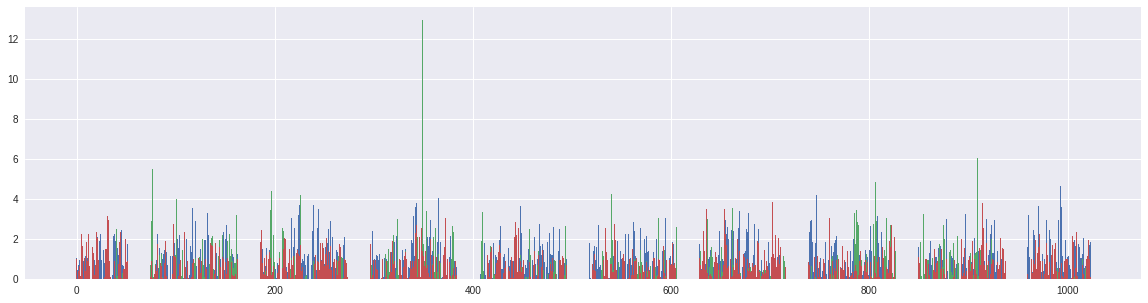

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

with h5py.File('seq.h5') as hf:
    y = hf['train_out'][:100]
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 5
    for i in range(3):
        plt.bar(range(y.shape[1]), y[0,:,i])

## Dilated Convolutionを用いた解析

### 配列解析の戦略

今回は配列データが入力であるような問題である．

配列データを扱うためには大きく３つの戦略があります．

一つ目は，配列中の順序情報は捨てて，配列をその特徴の集合とみなすことです．これはBag of Words（BoW）表現とよびます．このBoW表現は特徴に十分情報が含まれていれば強力な手法ですがDNA配列のような4種類の文字からなる配列やその部分配列だけではその特徴を捉えることは困難です．

二つ目は配列中の要素を左から右に順に読み込んでいき計算していく手法です．これは4章でも少し触れたRNNを用いて解析します．RNNは各時刻毎に入力を一つずつ読み取り内部状態を更新していきます．RNNの問題点はその計算が逐次的であり計算量が配列長に比例するという点です．現在の計算機は計算を並列化することで高速化を達成していますがRNNは計算を並列化することが困難です．もう一つの問題は遠距離間の関係を捉えることが難しいという点です．RNNはその計算方式から，計算の途中結果を全て固定長の内部状態ベクトルに格納する必要があります．遠距離間の関係を捉えようとすると，多くの情報を覚えておかなければなりませんが状態ベクトルサイズは有限なので，遠距離間の関係を捉えることが困難となっていきます．

三つ目は配列データを1次元の画像とみなし，画像処理の時と同様にCNNを用いて解析する手法です．CNNはRNNの場合と違って各位置の処理を独立に実行できるため並列に処理することができます．また，後述するDilated Convolutionを使うことで各位置の処理は遠距離にある情報を直接読み取ることができます．次の章でDilated Convolutionについてさらに詳しくみていきます．






### Dilated Convolution

従来の畳み込み層を使って配列解析をする場合を考えてみます．
以下の図のようにある位置の入力の情報は各層で隣接する位置からしか読み込まれません．どのくらい離れた位置から情報を取得するかはカーネルサイズによって決定され，カーネルサイズがKの時，Dだけ離れた距離にある情報を取得するためにはD/K層必要となります．今回の問題の場合Dは数百から数万，Kは3や5といった値ですので必要な層数も百から万といった数になってしまい現実的ではありません．

![orig conv](http://musyoku.github.io/images/post/2016-09-17/naive_conv.png)

[WaveNet: A Generative Model for Raw Audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)より引用

それに対し，Dilated Convolution（atrous convolutionやconvolution weith holesともよばれます）は読み取る場所をずらしたところからうけとります．例えばDilation=4の場合，4だけ離れた位置から情報を受け取ります．このDilatedを倍々にしていき，カーネルサイズを2とした場合，Dだけ離れた位置の情報を受取るには log_2 D層だけ必要になります．今回のDが数百から数万の場合，10から20層程度あれば済むことになります．

今回はこのDilated Convolutionを使うことで遠距離にある情報を考慮できるモデルを作成します．

![dilated convolution](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif)

[WAVENET: A GENERATIVE MODEL FOR RAW AUDIO, blog](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)より


### ブロック

それでは最初に，ネットワークの全体を設計します．
このネットワークは二つのブロックから構成されます．

１つ目のブロックは長さが$2^{17}$から配列を入力として長さが$2^{10}$のベクトルを出力とします．これにより入力の128 bpが出力の1つの位置に対応するようになります．これを実現しているのが、SqueezeBlockです．

二つ目のブロックは遠距離にある情報を考慮して各ベクトルの値を計算していく部分であり、DilatedBlockが担当します。

それでは，以下のコードを実行してみましょう．


In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import cupy as cp

bc = 16 # base channel

default_squeeze_params = [
    # out_ch, kernel, pool, dropout
    [bc, 21, 2, 0.05], #1 128 -> 64
    [bc*2, 7, 4, 0.05], #2  64 -> 16
    [bc*4, 7, 4, 0.05], #3  16 -> 4
    [bc*8, 7, 4, 0.05]  #4  4 -> 1
]


default_dilated_params = [
# out_ch, kernel, dilated
  [bc*8, 3, 1, 0.1],
  [bc*8, 3, 2, 0.1], 
  [bc*8, 3, 4, 0.1], 
  [bc*8, 3, 8, 0.1], 
  [bc*8, 3, 16, 0.1], 
  [bc*8, 3, 32, 0.1],
  [bc*8, 3, 64, 0.1]
]


class Net(chainer.Chain):

    def __init__(self, squeeze_params=default_squeeze_params, dilated_params=default_dilated_params, n_targets=10):
        super(Net, self).__init__()
        self._n_squeeze = len(squeeze_params)
        self._n_dilated = len(dilated_params)
        with self.init_scope():
            in_ch = 4
            for i, param in enumerate(squeeze_params):
                out_ch, kernel, pool, do_rate = param
                setattr(self, "s_{}".format(i), SqueezeBlock(in_ch, out_ch, kernel, pool, do_rate))
                in_ch = out_ch
            for i, param in enumerate(dilated_params):
                out_ch, kernel, dilated, do_rate = param
                setattr(self, "d_{}".format(i), DilatedBlock(out_ch, kernel, dilated, do_rate))
            self.l = L.ConvolutionND(1, None, n_targets, 1)
    
    def forward(self, x):
        # x : (B, X, 4)
        xp = cp.get_array_module(x)
        h = xp.transpose(x, (0, 2, 1))
        h = h.astype(xp.float32)
                
        for i in range(self._n_squeeze):
            h = F.forget(self["s_{}".format(i)], h)
    
        for i in range(self._n_dilated):
            h = F.forget(self["d_{}".format(i)], h)

        h = self.l(h)
        h = xp.transpose(h, (0, 2, 1))
        return h
 

このネットワークは初期化時の引数としてSqueezeBlockに関するパラメータと，DilatedBlockに関するパラメータを受け取ります．

それぞれ，出力チャンネル，カーネルサイズ，プーリングの三つ組からなるリストと，出力チャンネル，カーネルサイズ，dilatedサイズの三つ組からなるリストを受け取ります．

次に，ブロックの定義をします．

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import cupy as cp

class WNConvolutionND(L.ConvolutionND):
    def __init__(self, *args, **kwargs):
        super(WNConvolutionND, self).__init__(*args, **kwargs)
        self.add_param('g', self.W.data.shape[0])
        norm = np.linalg.norm(self.W.data.reshape(
            self.W.data.shape[0], -1), axis=1)
        self.g.data[...] = norm

    def __call__(self, x):
        norm = F.batch_l2_norm_squared(self.W) ** 0.5
        channel_size = self.W.data.shape[0]
        norm_broadcasted = F.broadcast_to(
            F.reshape(norm, (channel_size, 1, 1)), self.W.data.shape)
        g_broadcasted = F.broadcast_to(
            F.reshape(norm, (channel_size, 1, 1)), self.W.data.shape)
        return F.convolution_nd(
            x, g_broadcasted * self.W / norm_broadcasted, self.b, self.stride,
            self.pad, self.cover_all, self.dilate)

class SqueezeBlock(chainer.Chain):  
    def __init__(self, in_ch, out_ch, kernel, pool, do_rate):
        super(SqueezeBlock, self).__init__()
        
        self.pool = pool
        self.do_rate = do_rate
        with self.init_scope():
            pad = kernel // 2
            self.conv = WNConvolutionND(1, in_ch, out_ch*2, kernel, pad=pad, stride=pool)
      
    def forward(self, x):
        h = F.dropout(self.conv(x), self.do_rate)
        h, g = F.split_axis(h, 2, 1)
        h = h * F.sigmoid(g)
        return h

class DilatedBlock(chainer.Chain):
     def __init__(self, out_ch, kernel, dilate, do_rate):
        super(DilatedBlock, self).__init__()
        self.do_rate = do_rate
        with self.init_scope():
            self.conv = WNConvolutionND(1, out_ch, out_ch*2, kernel, pad=dilate, dilate=dilate)
            self.conv1x1 = WNConvolutionND(1, out_ch, out_ch, 1)
      
     def forward(self, x):
        h = F.dropout(self.conv(x), self.do_rate)
        h, g = F.split_axis(h, 2, 1)
        h = h * F.sigmoid(g)
        h = self.conv1x1(h)
        return h + x


WeightNormalizationはパラメータの表現を長さと向きに分解して表現する手法で，今回の系列問題のような場合に使われる正規化法です．コード中ではWeightNormalizationが適用された畳み込み層である`WNConvolutionND`が定義されています.

SqueezeBlockは配列を縮めていき，長さが$2^{17}$の配列を$2^{10}$に縮めるためのブロックです．
1次元配列を扱うためWNConvolutionNDを使い，最初の引数で1次元配列であることを示す`1`を指定しています．
また，活性化関数では$h = Wx * sigmoid(Ux)$と表されるGated Linear Unitを利用しています．これは，2倍のチャンネル数を持つ出力を計算した後にチャンネルをそれぞれ半分にし$(Wx, Ux)$片方にsigmoid関数を適用しています．

DilatedBlockはすでに長さ1024の長さになった配列に対し，Dilated Convolutionを使って遠距離にある情報も使って計算していく部分です．引数としてdilatedを受け取ります．Dilated Convolutionを使う場合は通常のConvolution層（今回はConvolutionNDだが，Convolution2Dも同様）の引数にdilatedを加えるだけで計算できます．

また，計算の際は入力結果に現在の結果を足しこみます．これはResNetと呼ばれるネットワークで提案された手法です．これにより，学習がしやすくなります．



それでは，試しにネットワークを構築して，そこにサンプルデータを流してみましょう．



In [17]:
import numpy as np
n = Net()
size = 131072 # 128 * 1024
batchsize = 4
x = np.empty((batchsize, size, 4), dtype=np.bool)
y = n.forward(x)
print(y.shape)

(4, 1024, 3)


```
(4, 1024, 3)
```



ここで，もともとバッチサイズ(B)=4, 入力長(L)=131072, 入力チャンネル数(C)=4だった配列が計算後はB=4, L=1024, C=3の配列となりました．

今回の学習では対数ポアソン損失関数を利用します．これはモデルはポアソン分布の唯一のパラメータである平均を出力し，そのポアソン分布を学習データを使った最尤推定をします．この際，学習対象パラメータ以外は無視しています．
また，この最適化関数の最小値はそのままだと$0$にはならので，最小値である$t \log t$をひいておき，損失関数の最小値が$0$となるようにします．

In [0]:
import chainer.functions as F
import math
import sklearn
import numpy as np

def log_poisson_loss(log_x, t):
    #return F.mean(F.exp(log_x) - t * log_
    loss =  F.mean(F.exp(log_x) - t * log_x) 
    t = chainer.cuda.to_cpu(t.astype(np.float32))  
    offset = F.mean(cp.array(t - t * np.ma.log(t)))
    return loss - offset


def log_r2_score(log_x, t):
    return F.r2_score(F.exp(log_x), t)

また，学習率の調整にCosineSchedulerを使います．ニューラルネットワークの学習では，徐々に学習率を小さくしていくと，より汎化性能の高い解を見つけられることがわかっています．焼きなまし法のように最初は学習率を高くして極小解にはまらないようにし，後半は徐々に学習率を0に近づけていき収束させるというものです．
CosineSchedulerはCosine関数の0度から90度までの変化のように学習率を変化させます．また学習は初期が不安定なので最初にn_warmup回，学習率を0から初期学習率まで線形に増やしていきます．


In [0]:
from chainer import training
import numpy as np
import math

class CosineScheduler(training.Extension):

    def __init__(self, attr='lr', init_val=0.0001, n_decays=200, n_warmups=3, target=None, optimizer=None):
        self._attr = attr
        self._target = target
        self._optimizer = optimizer
        self._min_loss = None
        self._last_value = None
        self._init_val = init_val
        self._n_decays = n_decays - n_warmups
        self._decay_count = 0
        self._n_warmups = n_warmups

    def __call__(self, trainer):
        updater = trainer.updater
        optimizer = self._get_optimizer(trainer)
        epoch = updater.epoch
        if epoch < self._n_warmups:
            value = self._init_val / (self._n_warmups + 1) * (epoch + 1)
        else:
            value = 0.5 * self._init_val * (1 + math.cos(math.pi * (epoch - self._n_warmups) / self._n_decays))
        self._update_value(optimizer, value)


    def _get_optimizer(self, trainer):
        return self._optimizer or trainer.updater.get_optimizer('main')

    def _update_value(self, optimizer, value):
        setattr(optimizer, self._attr, value)
        self._last_value = value

最後に学習中に訓練データに意味を変えない変化を加えるData Augmentationを適用します．これは画像において回転させたり，平行移動させたりする場合と同じです．
まず，入力配列を反転させたものを入力としても出力を反転させたものと一致するはずなので0.5の確率で入力と出力を同時に反転させます．また，今回は128bp毎にカバレッジ値を予測していますが，数塩基（例えば4~8など）移動したとしてもカバレッジ値は同じ程度になることが規定されます．そこで最大max_shift分だけ配列を前後にシフトします（完全にランダムな塩基配列を余った部分に入れると実際の塩基配列の分布と変わる可能性があるのでここではroll()関数を巡回シフトしています）．

In [0]:
import chainer
import random

class PreprocessedDataset(chainer.dataset.DatasetMixin):

    def __init__(self, xs, ys, max_shift):
        self.xs = xs
        self.ys = ys
        self.max_shift = max_shift

    def __len__(self):
        return len(self.xs)

    def get_example(self, i):
        # It applies following preprocesses:
        #     - Cropping
        #     - Random flip

        x = self.xs[i]
        y = self.ys[i]


        s = random.randint(-self.max_shift, self.max_shift)
        x = np.roll(x, s, axis=0)
        return x, y

これで全部準備ができました．残りはchainerのtrainerを改造して学習するだけです．以下のコードを実行してください．

元々のデータ全体では学習に時間がかかるので、データ/`ratio`分だけを学習、検証用データとして利用します。今回`ratio`は20に設定されています。
30分程度で学習が完了します．

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
from chainer.training import extensions
from chainer import training
import h5py

ml_h5 = h5py.File('seq.h5')

train_x = ml_h5['train_in']
train_y = ml_h5['train_out']

valid_x = ml_h5['valid_in']
valid_y = ml_h5['valid_out']

test_x = ml_h5['test_in']
test_y = ml_h5['test_out']

ratio = 1
train_x = train_x[:len(train_x)//ratio]
train_y = train_y[:len(train_y)//ratio]
valid_x = valid_x[:len(valid_x)//ratio]
valid_y = valid_y[:len(valid_y)//ratio]


max_shift_for_data_augmentation = 3
train = PreprocessedDataset(train_x, train_y, max_shift_for_data_augmentation)
val = chainer.datasets.TupleDataset(valid_x, valid_y)

batchsize = 8

train_iter = chainer.iterators.SerialIterator(train, batchsize)
val_iter = chainer.iterators.SerialIterator(val, batchsize, repeat=False, shuffle=False)

model = L.Classifier(Net(), lossfun=log_poisson_loss, accfun=log_r2_score)

lr = 0.001
optimizer = chainer.optimizers.Adam(alpha=lr, beta1=0.97, beta2=0.98)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(threshold=0.01))


updater = training.updaters.StandardUpdater(
     train_iter, optimizer, device=0)

n_epochs = 10
n_warmups = 3
out = "out"
trainer = training.Trainer(updater, (n_epochs, 'epoch'), out=out)
trainer.extend(CosineScheduler(attr='alpha', init_val=lr, n_decays=n_epochs, n_warmups=n_warmups), trigger=(1, 'epoch'))

trainer.extend(extensions.Evaluator(val_iter, model, device = 0))
trainer.extend(extensions.LogReport(trigger=(0.2, 'epoch')))
trainer.extend(extensions.snapshot_object(model, 'model_epoch_{.updater.epoch}'), trigger=(1, 'epoch'))

trainer.extend(extensions.PrintReport(
          ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger = (0.1, 'epoch'))

# trainer.extend(extensions.ProgressBar())
           
trainer.run()


学習が成功したならば，ディレクトリのout以下に学習されたモデルが出力されているはずです．実際にモデルが出力されているのかを確認しましょう．

In [0]:
!ls -l out/

次に，学習したモデルを用いてテストデータに対しても予測してみます．次のようにして学習が終わったモデルを読み込み，テストデータに対してモデルを適用してみましょう．

In [26]:
import chainer
import chainer.links as L
%matplotlib inline
import matplotlib.pyplot as plt

model_n_epoch = 60
out_dir = 'out'
model = L.Classifier(Net())
chainer.serializers.load_npz('{}/model_epoch_{}'.format(out_dir, model_n_epoch), model)
predictor = model.predictor

print(len(test_x))
with chainer.no_backprop_mode():
    test_y_estimated = F.exp(predictor(test_x[:1]))

test_y = test_y[:1]

print(test_y_estimated.shape)     
print(test_y_estimated[0,:,0])



500
(1, 1024, 10)
variable([1.0371194 1.1439321 2.016534  ... 1.8804296 1.7855631 1.1112121])


結果を抜粋して表示してみましょう．ここでは3つ目（i=2）の出力について正解と推定結果を出力しています．今回の場合，学習データを絞り（クラス数を10とした），学習回数も少ないため精度はそれほど高くありませんが，ピークをいくつか捉えられていることがわかると思います．

<Container object of 1024 artists>

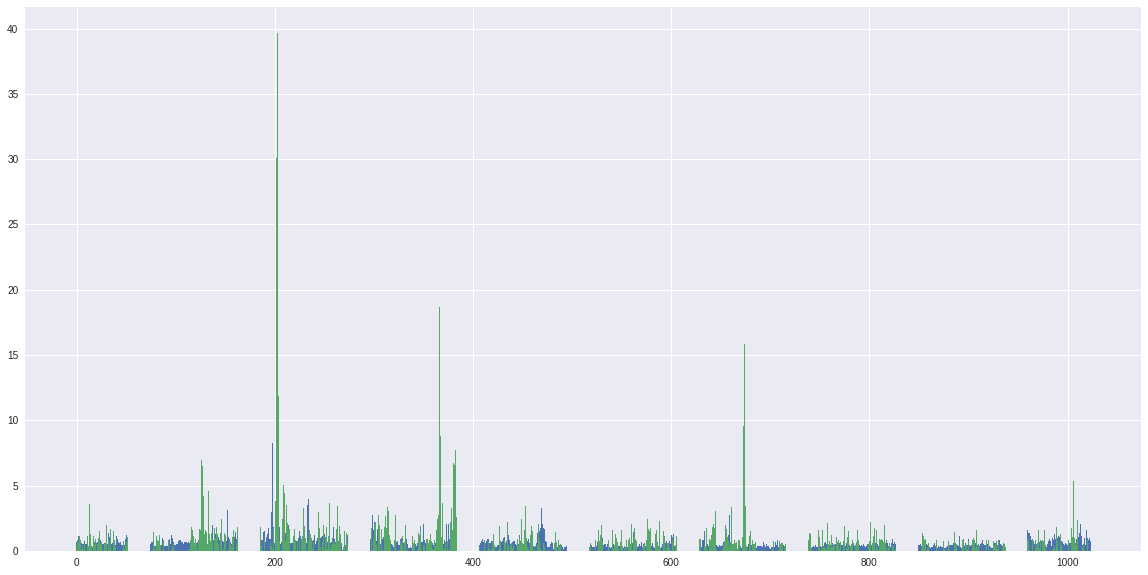

In [27]:
y = test_y_estimated.data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
i = 2
plt.bar(range(y.shape[1]), y[0,:,i])
plt.bar(range(y.shape[1]), test_y[0,:,i])

時間に余裕があれば学習のn_epochsを60から200程度に増やしたり，総数を増やしたり，チャンネル数を増やしたり，学習データ数（ratio=20をratio=5などにして）に増やしたりして，より高精度なモデルが学習できるのかを調べてみましょう．


[1] "Sequential regulatory activity prediction across chromosomes with convolutional neural networks", D. R. Kelly and et al., Genome Res. 2018. 28: 739-750